In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import findspark
findspark.init('/usr/local/Cellar/apache-spark/3.0.0/libexec')
from pyspark.sql import SparkSession

In [3]:
spark1 = SparkSession.builder \
 .master("local") \
 .appName("recommendation-engine") \
 .config("spark.some.config.option", "some-value") \
 .getOrCreate()

## Objective

The goal is to develop a model that predicts the movies that a user might like based on collaborative filtering. We will be using ALS and Spark.

In [4]:
spark1

## Load data 

In [5]:
movies = spark1.read.csv('movies.csv', header=True, inferSchema=True, sep=',')
ratings = spark1.read.csv('ratings.csv', header=True, inferSchema=True, sep=',')

Let's create two temporary views of the table `movies` and `ratings`on memory. This will enable us to run sql queries against these two tables.

In [6]:
movies.createOrReplaceTempView("MOVIES")
ratings.createOrReplaceTempView("RATINGS")

The dataset here is not really big, it will fit in RAM without any doubt. However let's suppose it is big therefore we will use Spark.

In [7]:
# get data shape
print(f"Movies dataset is composed of {movies.count()} rows and {len(movies.columns)} columns")
print('\nDataset schema')
movies.printSchema()

Movies dataset is composed of 9742 rows and 3 columns

Dataset schema
root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [8]:
print(f"Ratings dataset is composed of {ratings.count()} rows and {len(ratings.columns)} columns")
print('\nDataset schema')
ratings.printSchema()

Ratings dataset is composed of 100836 rows and 4 columns

Dataset schema
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



Are there any duplicate movies? 

In [9]:
movies.select(['movieId']).distinct().count() == movies.count()

True

There're no duplicate id's, therefore all the movies in this table are unique.

`ratings` contains the ratings that each user gave to movies. **How many unique users have we got in our dataset?**

In [93]:
ratings.select(['userId']).distinct().count()

610

We can also get the same result using SQL queries.

In [11]:
n_users = spark1.sql('SELECT COUNT(DISTINCT userId) from RATINGS').collect()[0].asDict()['count(DISTINCT userId)']
n_users

610

How many movies are there in ratings table?

In [12]:
n_movies = spark1.sql('SELECT COUNT(DISTINCT movieId) from RATINGS').collect()[0].asDict()['count(DISTINCT movieId)']
n_movies

9724

Let's print some movies

In [20]:
movies.show(3)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
+-------+--------------------+--------------------+
only showing top 3 rows



How many movies are there per `genre`?

- toPandas() action collects all the records from all the workers, returns them to the driver, and then converts the results into a pandas DataFrame

In [45]:
genres_count = movies.groupBy('genres').count().toPandas()

In [50]:
print(f"{genres_count.size/1024:.2f}ko")

1.86ko


- it is easier to manipulate pandas dataframes for EDA purposes.
- `genres_count` weights only 1.86Ko we can sefely collect it and load it to the Host PC RAM.

In [69]:
genres_count.sample(4)

,genres,count
221,Animation|Horror|Mystery|Thriller,1
724,Drama|Sci-Fi,30
562,Adventure|Fantasy|Sci-Fi,3
321,Children|Comedy|Fantasy|Horror,2


In [67]:
dict_genres = {}
for row in genres_count.itertuples():
    for genre in row.genres.split('|'):
        dict_genres[genre] = row.count + dict_genres.get(genre, 0)

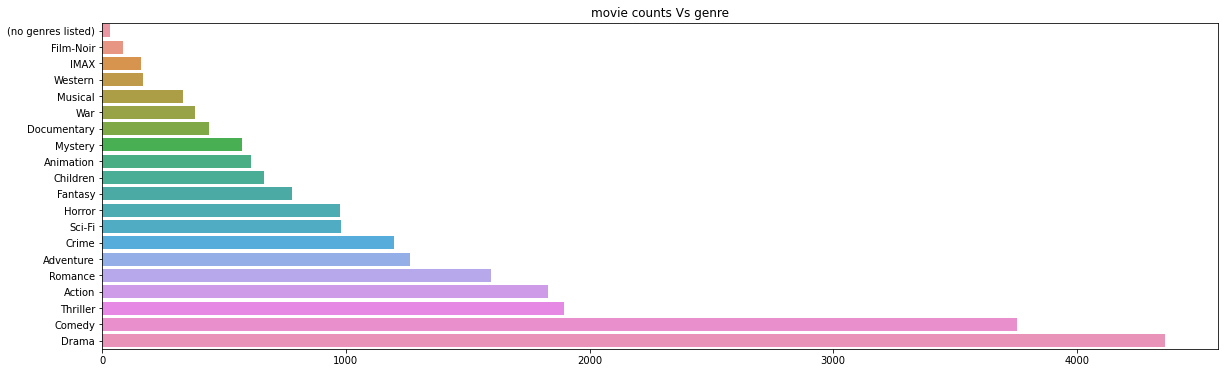

In [175]:
dict_genres_sorted = {k: v for k, v in sorted(dict_genres.items(), key=lambda item: item[1])}
plt.figure(figsize=(20,6))
sns.barplot(y=list(dict_genres_sorted.keys()), x=list(dict_genres_sorted.values()))
plt.title('movie counts Vs genre')
plt.show()

## Sparsity

In [13]:
n_interactions = ratings.count()
sparsity = 1 - (n_interactions/(n_users*n_movies))

f"{sparsity:.2%} of the interaction matrix is composed of zeros"

'98.30% of the interaction matrix is composed of zeros'

Let's optimize sparsity by removing movies that have less than 4 interaction with users

In [14]:
thresh = 4
query = f'''
SELECT movieId, COUNT(userId) as cnt FROM RATINGS 
GROUP BY movieId 
HAVING cnt>{thresh}
'''

filtered_movies = spark1.sql(query).select(['movieId'])
f"{filtered_movies.count()} movies having a minimum of {thresh}"

'3650 movies having a minimum of 4'

In [15]:
filtered_movies.createOrReplaceTempView('FILTERED_MOVIES')

In [16]:
query = f'''
SELECT * FROM RATINGS
WHERE movieId IN 
    (SELECT movieId
     FROM FILTERED_MOVIES
    )
'''

ratings_optimized = spark1.sql(query)

In [17]:
n_interactions = ratings_optimized.count()
n_movies = ratings_optimized.select(['movieId']).distinct().count()

sparsity = 1 - (n_interactions/(n_users*n_movies))

f"{sparsity:.2%} of the interaction matrix is composed of zeros"

'95.95% of the interaction matrix is composed of zeros'

## Summary statistics

In [21]:
from pyspark.sql.functions import min, max, avg

In [20]:
query = f'''
SELECT * FROM 
    (SELECT movieId, AVG(rating) as avg_rating, COUNT(*) as votes FROM RATINGS
     GROUP BY movieId)

ORDER BY votes DESC, avg_rating  DESC
LIMIT 10
'''

top10_movies = spark1.sql(query)
top10_movies.show()

+-------+-----------------+-----+
|movieId|       avg_rating|votes|
+-------+-----------------+-----+
|    356|4.164133738601824|  329|
|    318|4.429022082018927|  317|
|    296|4.197068403908795|  307|
|    593|4.161290322580645|  279|
|   2571|4.192446043165468|  278|
|    260|4.231075697211155|  251|
|    480|             3.75|  238|
|    110|4.031645569620253|  237|
|    589|3.970982142857143|  224|
|    527|            4.225|  220|
+-------+-----------------+-----+



To get movies name let's merge `top10_movies` with `movies` table

In [22]:
top10_movies.join(movies, on='movieId', how='left').show()

+-------+-----------------+-----+--------------------+--------------------+
|movieId|       avg_rating|votes|               title|              genres|
+-------+-----------------+-----+--------------------+--------------------+
|    356|4.164133738601824|  329| Forrest Gump (1994)|Comedy|Drama|Roma...|
|    318|4.429022082018927|  317|Shawshank Redempt...|         Crime|Drama|
|    296|4.197068403908795|  307| Pulp Fiction (1994)|Comedy|Crime|Dram...|
|    593|4.161290322580645|  279|Silence of the La...|Crime|Horror|Thri...|
|   2571|4.192446043165468|  278|  Matrix, The (1999)|Action|Sci-Fi|Thr...|
|    260|4.231075697211155|  251|Star Wars: Episod...|Action|Adventure|...|
|    480|             3.75|  238|Jurassic Park (1993)|Action|Adventure|...|
|    110|4.031645569620253|  237|   Braveheart (1995)|    Action|Drama|War|
|    589|3.970982142857143|  224|Terminator 2: Jud...|       Action|Sci-Fi|
|    527|            4.225|  220|Schindler's List ...|           Drama|War|
+-------+---

## Modelisation

In [23]:
SEED = 1
train, test = ratings_optimized.randomSplit([0.8, 0.2], seed=SEED)

In [24]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          nonnegative = True, implicitPrefs = False, coldStartStrategy='drop')

param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50]) \
            .addGrid(als.maxIter, [5, 50])\
            .build()
           
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
print ("Nbr of hyperparameters combinations ", len(param_grid))

Nbr of hyperparameters combinations  4


In [25]:
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

In [ ]:
#Fit cross validator to the 'train' dataset
model = cv.fit(train)

#Extract best model from the cv model above
best_model = model.bestModel

## Final Model

In [27]:
als = ALS(userCol='userId', itemCol='movieId', ratingCol='rating', rank=10,
            maxIter=20, regParam=0.1, coldStartStrategy='drop', nonnegative=True, implicitPrefs=False)

In [28]:
model = als.fit(train)

In [29]:
predictions = model.transform(test)
predictions.show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   436|    471|   3.0| 833530187| 3.5376735|
|   520|    471|   5.0|1326609921|  3.589494|
|   136|    471|   4.0| 832450058| 3.6335943|
|   273|    471|   5.0| 835861348| 4.2163095|
|   448|    471|   4.0|1178980875| 3.5326889|
|   260|    471|   4.5|1109409455|  3.921546|
|   357|    471|   3.5|1348627082|   4.10469|
|    44|    833|   2.0| 869252237|  3.188034|
|   307|    833|   1.0|1186172725| 1.0259031|
|   492|    833|   4.0| 863976674| 3.1052873|
|   606|   1088|   3.0|1171926956| 2.9679475|
|   599|   1088|   2.5|1498515232|  2.541874|
|   563|   1088|   4.0|1440793700| 3.1622243|
|   307|   1088|   3.0|1186162146|   2.66366|
|   555|   1088|   4.0| 978822670| 3.2510967|
|   116|   1088|   4.5|1337195649| 3.4005952|
|   483|   1088|   3.0|1215895737|  3.197276|
|   462|   1238|   3.5|1370129249| 3.4404497|
|   156|   1238|   4.0| 946799272|

In [30]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
evaluator.evaluate(predictions)

0.8442918550617431

## Prediction

In [36]:
predictions.show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   436|    471|   3.0| 833530187| 3.5376735|
|   520|    471|   5.0|1326609921|  3.589494|
|   136|    471|   4.0| 832450058| 3.6335943|
|   273|    471|   5.0| 835861348| 4.2163095|
|   448|    471|   4.0|1178980875| 3.5326889|
|   260|    471|   4.5|1109409455|  3.921546|
|   357|    471|   3.5|1348627082|   4.10469|
|    44|    833|   2.0| 869252237|  3.188034|
|   307|    833|   1.0|1186172725| 1.0259031|
|   492|    833|   4.0| 863976674| 3.1052873|
|   606|   1088|   3.0|1171926956| 2.9679475|
|   599|   1088|   2.5|1498515232|  2.541874|
|   563|   1088|   4.0|1440793700| 3.1622243|
|   307|   1088|   3.0|1186162146|   2.66366|
|   555|   1088|   4.0| 978822670| 3.2510967|
|   116|   1088|   4.5|1337195649| 3.4005952|
|   483|   1088|   3.0|1215895737|  3.197276|
|   462|   1238|   3.5|1370129249| 3.4404497|
|   156|   1238|   4.0| 946799272|

In [45]:
from pyspark.sql.functions import col
print("User 60's Ratings:")
train.filter(col("userId") == 60).join(movies, on='movieId', how='inner').sort("rating", ascending = False).show()

User 60's Ratings:
+-------+------+------+----------+--------------------+--------------------+
|movieId|userId|rating| timestamp|               title|              genres|
+-------+------+------+----------+--------------------+--------------------+
|  58559|    60|   5.0|1393542075|Dark Knight, The ...|Action|Crime|Dram...|
|    858|    60|   5.0|1393542055|Godfather, The (1...|         Crime|Drama|
|    527|    60|   5.0|1393542064|Schindler's List ...|           Drama|War|
|    318|    60|   4.0|1393542053|Shawshank Redempt...|         Crime|Drama|
|    362|    60|   4.0|1393541920|Jungle Book, The ...|Adventure|Childre...|
|   3386|    60|   4.0|1393541937|          JFK (1991)|Drama|Mystery|Thr...|
|   6016|    60|   4.0|1393542073|City of God (Cida...|Action|Adventure|...|
|    783|    60|   4.0|1393541788|Hunchback of Notr...|Animation|Childre...|
|   1242|    60|   4.0|1393541757|        Glory (1989)|           Drama|War|
|   2150|    60|   4.0|1393541897|Gods Must Be Craz...|  

In [43]:
print("User 63's Recommendations:")
predictions.filter(col("userId") == 60).join(movies, on='movieId', how='inner').show()

User 63's Recommendations:
+-------+------+------+----------+----------+--------------------+--------------+
|movieId|userId|rating| timestamp|prediction|               title|        genres|
+-------+------+------+----------+----------+--------------------+--------------+
|   3424|    60|   4.0|1393541967| 3.4226027|Do the Right Thin...|         Drama|
|    805|    60|   4.0|1393541754|   3.11559|Time to Kill, A (...|Drama|Thriller|
+-------+------+------+----------+----------+--------------------+--------------+

